<a href="https://www.kaggle.com/code/sreejitamukherjee/mastercard-stock-data-forecasting?scriptVersionId=137521806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv
/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
   
# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

In [3]:
data= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
market_data=pd.read_csv('/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv')

In [4]:
data.head(1000)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0
...,...,...,...,...,...,...,...,...
995,2010-05-10,22.052394,22.253135,21.518967,21.705572,29826000,0.0,0.0
996,2010-05-11,21.432253,21.439794,20.850762,21.039251,29271000,0.0,0.0
997,2010-05-12,21.205125,22.262554,21.166484,21.923271,29123000,0.0,0.0
998,2010-05-13,21.930813,22.611262,21.729128,21.894058,22049000,0.0,0.0


In [5]:
data['Dividends'].describe().T

count    3872.000000
mean        0.002329
std         0.025851
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.440000
Name: Dividends, dtype: float64

In [6]:
data['Stock Splits'].describe().T

count    3872.000000
mean        0.002583
std         0.160706
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: Stock Splits, dtype: float64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3872.0,1.048968e+02,1.062455e+02,3.748967,2.234720e+01,7.081008e+01,1.476884e+02,3.926539e+02
High,3872.0,1.059561e+02,1.073036e+02,4.102467,2.263800e+01,7.137590e+01,1.486454e+02,4.005215e+02
Low,3872.0,1.037693e+02,1.050501e+02,3.739664,2.203446e+01,7.022400e+01,1.468220e+02,3.897478e+02
Close,3872.0,1.048827e+02,1.061687e+02,4.083861,2.230039e+01,7.085608e+01,1.476884e+02,3.946857e+02
Volume,3872.0,1.232250e+07,1.759665e+07,641100.000000,3.529475e+06,5.891750e+06,1.319775e+07,3.953430e+08
Dividends,3872.0,2.329029e-03,2.585085e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e-01
Stock Splits,3872.0,2.582645e-03,1.607061e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


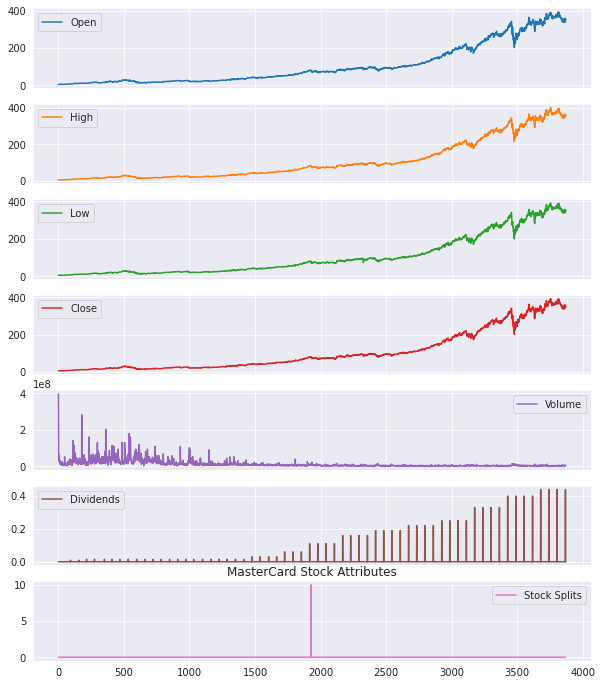

In [9]:
data.plot(subplots = True, figsize = (10,12))
plt.title('MasterCard Stock Attributes')
plt.show()

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

# Extract the year from the 'Date' column and create a new DataFrame
year_df = pd.DataFrame({'Year': data['Date'].dt.year}, index=data.index)

# Concatenate the 'data' DataFrame with the 'year_df' DataFrame along the columns (axis=1)
data = pd.concat([data['Date'], year_df, data.drop(['Date'], axis=1)], axis=1)

In [11]:
data.head()

,Date,Year,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,2006,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,2006,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,2006,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,2006,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,2006,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


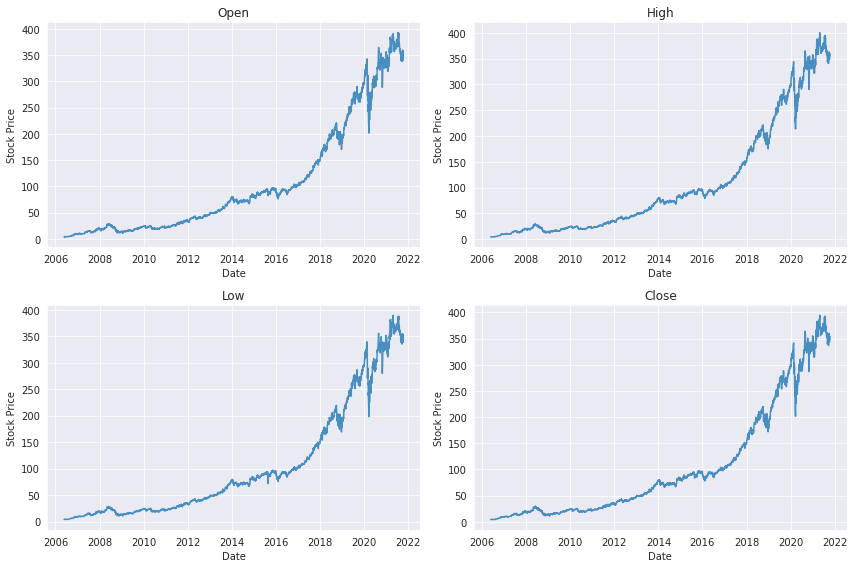

In [12]:

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define the column names for plotting
columns_to_plot = ['Open', 'High', 'Low', 'Close']

# Create subplots using a loop
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    axes[row, col].plot(data['Date'], data[column], alpha=0.8)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].set_title(column)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()

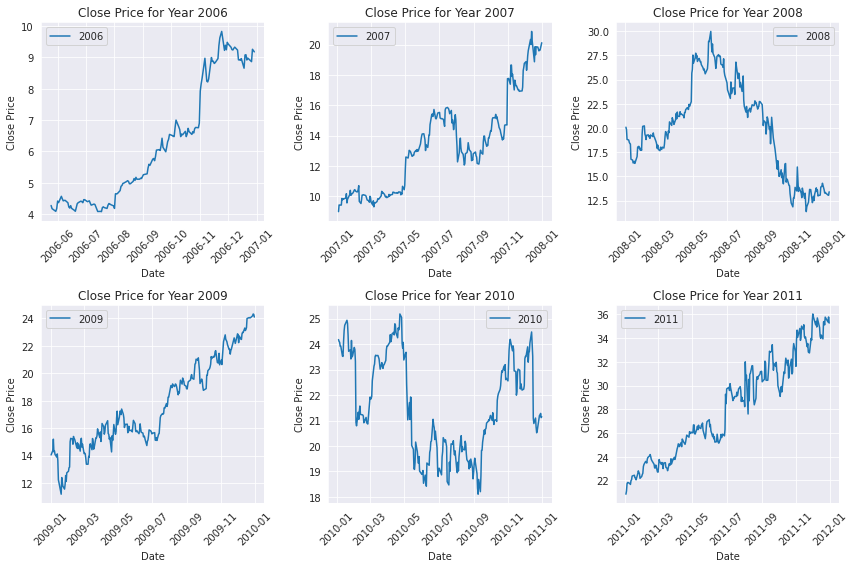

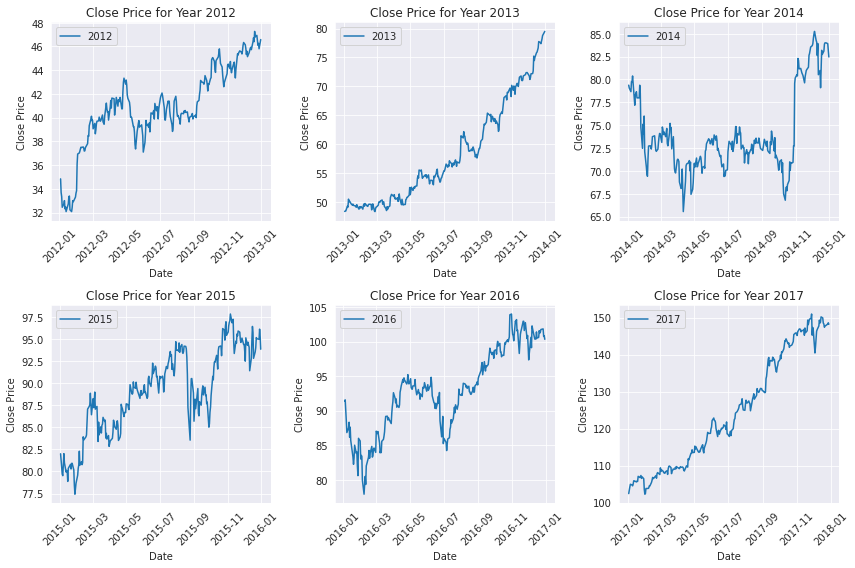

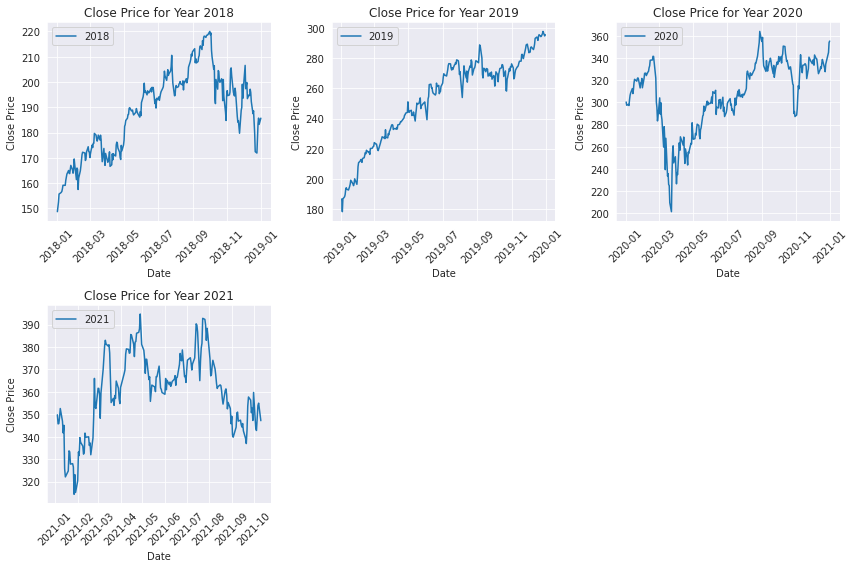

In [13]:
# Get unique years in the data
years = data['Year'].unique()

# Calculate the number of years to plot in each figure
years_per_figure = 6

# Calculate the number of figures needed
num_figures = (len(years) - 1) // years_per_figure + 1

# Loop through the figures
for fig_num in range(num_figures):
    start_year = fig_num * years_per_figure
    end_year = start_year + years_per_figure
    years_subset = years[start_year:end_year]

    # Create a new figure and set the size
    plt.figure(figsize=(12, 8))

    # Create subplots for each year in the subset
    for i, year in enumerate(years_subset, 1):
        plt.subplot(2, 3, i)
        year_data = data[data['Year'] == year]
        plt.plot(year_data['Date'], year_data['Close'], label=year)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(f'Close Price for Year {year}')
        plt.legend()
        
        plt.xticks(rotation=45)

    # Adjust layout to avoid overlapping labels
    plt.tight_layout()

    # Show the figure
    plt.show()

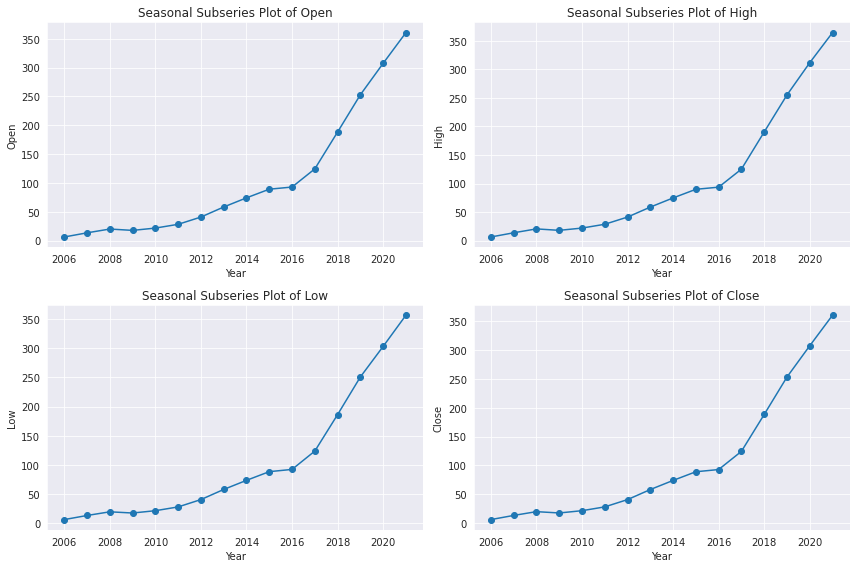

In [14]:
## Define the column names for plotting
columns_to_plot = ['Open', 'High', 'Low', 'Close']

# Create subplots using a loop
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterate over each column and create the seasonal subseries plot
for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2

    # Group the data by 'Year' and calculate the mean for each year
    pivot_data = data.groupby('Year')[column].mean()

    # Plot the seasonal subseries
    axes[row, col].plot(pivot_data.index, pivot_data.values, marker='o', linestyle='-')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel(column)
    axes[row, col].set_title(f'Seasonal Subseries Plot of {column}')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()

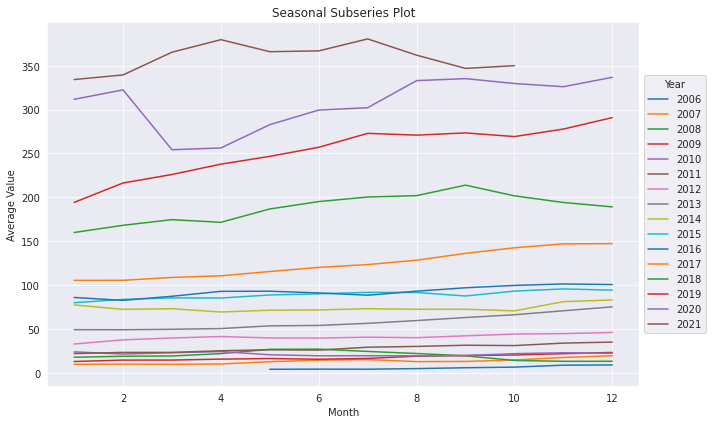

In [15]:
# Convert the 'Date' column to datetime if it's not already in datetime format
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Create a pivot table to group the data by Year and Month
pivot_data = data.pivot_table(index='Month', columns='Year', values='Close', aggfunc='mean')

# Create a seasonal subseries plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data.plot(ax=ax)

# Set plot properties
ax.set_xlabel('Month')
ax.set_ylabel('Average Value')
ax.set_title('Seasonal Subseries Plot')
ax.legend(title='Year', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

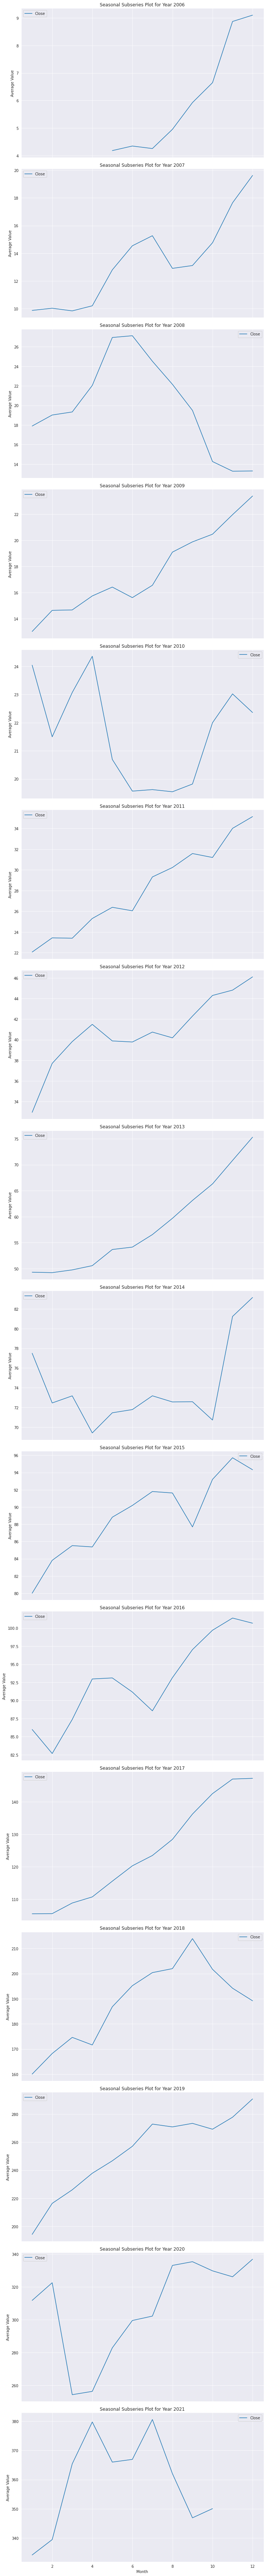

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime if it's not already in datetime format
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Get the unique years in the data
years = data['Year'].unique()  # First 6 years

# Create a seasonal subseries plot for each year
fig, axes = plt.subplots(len(years), 1, figsize=(10, 6 * len(years)), sharex=True)

# Loop through each year and create subplots
for i, year in enumerate(years):
    year_data = data[data['Year'] == year]
    pivot_data = year_data.pivot_table(index='Month', values='Close', aggfunc='mean')
    ax = axes[i]
    pivot_data.plot(ax=ax)
    ax.set_ylabel('Average Value')
    ax.set_title(f'Seasonal Subseries Plot for Year {year}')

# Set common x-axis label
plt.xlabel('Month')

# Adjust layout to create more spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()


<Figure size 720x432 with 0 Axes>

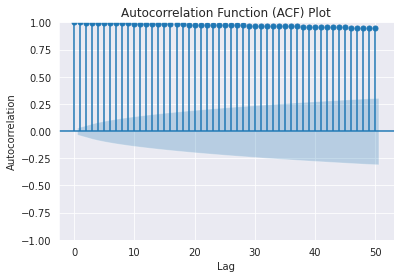

In [17]:
from statsmodels.graphics.tsaplots import plot_acf



# Plot the ACF plots
plt.figure(figsize=(10, 6))
plot_acf(data['Close'], lags=50)  # You can adjust the 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

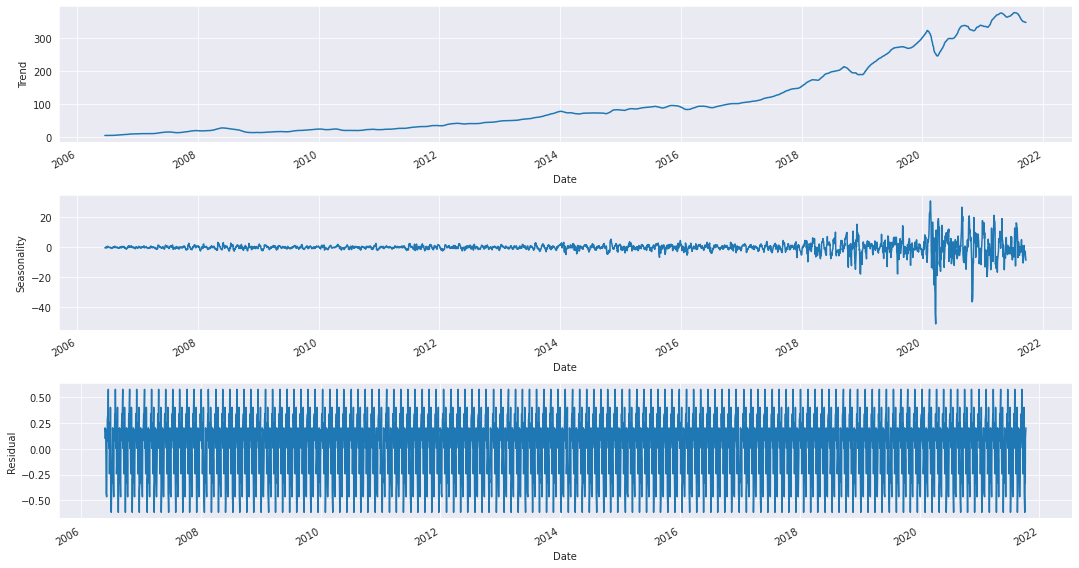

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose


data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Perform seasonal decomposition with specified frequency
res = seasonal_decompose(data['Close'], model='additive', period=30)

# Create subplots to display the decomposition results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

# Plot the decomposed components
res.trend.plot(ax=ax1, ylabel="Trend")
res.resid.plot(ax=ax2, ylabel="Seasonality")
res.seasonal.plot(ax=ax3, ylabel="Residual")

# Display the plots
plt.tight_layout()
plt.show()


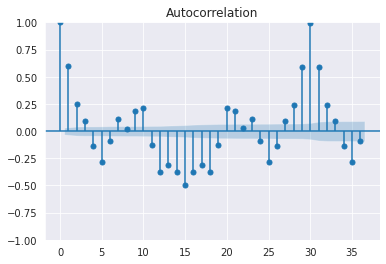

In [19]:
plot_acf(res.seasonal)
plt.show()

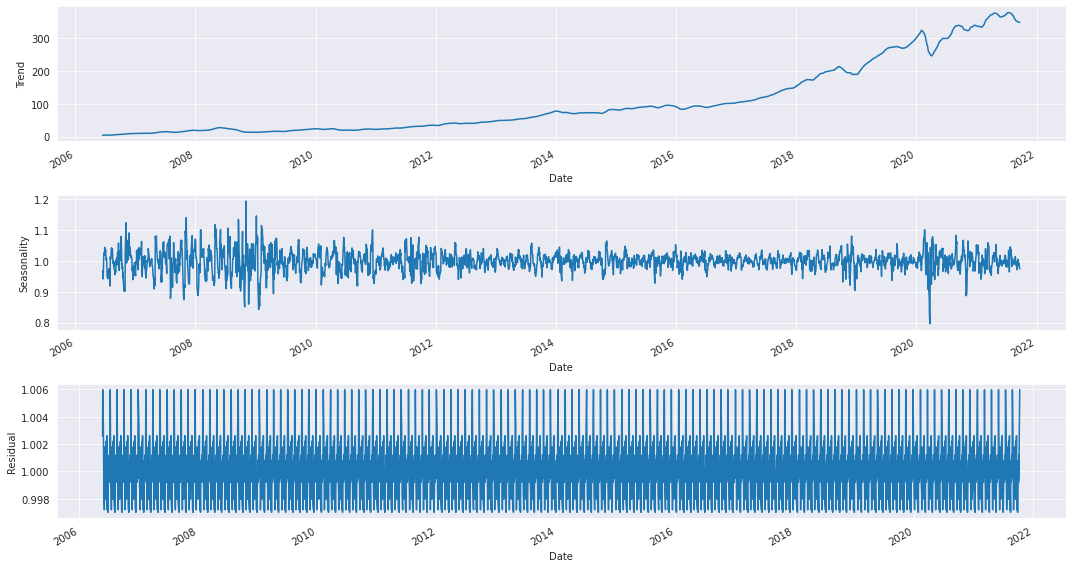

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose




# Perform seasonal decomposition with specified frequency
res = seasonal_decompose(data['Close'], model='multiplicative', period=30)

# Create subplots to display the decomposition results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

# Plot the decomposed components
res.trend.plot(ax=ax1, ylabel="Trend")
res.resid.plot(ax=ax2, ylabel="Seasonality")
res.seasonal.plot(ax=ax3, ylabel="Residual")

# Display the plots
plt.tight_layout()
plt.show()

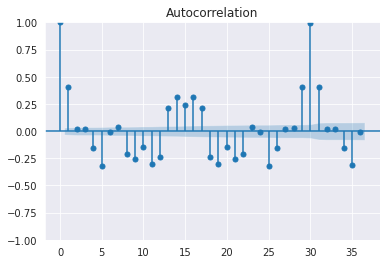

In [21]:
plot_acf(res.seasonal)
plt.show()

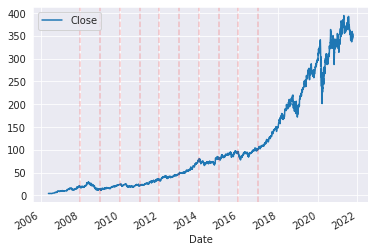

In [22]:
# Calculate the differences
data_diff = data['Close'].diff()

# Plot the original data
ax = data['Close'].plot()
ax.legend(loc='upper left')

# Plot the differences
for yr in range(2008, 2018):
    ax.axvline(pd.to_datetime(str(yr) + "-01-01"), color="red", linestyle="--", alpha=0.2)

plt.show()

In [23]:
data_diff.iloc[0] = 0

<Figure size 720x432 with 0 Axes>

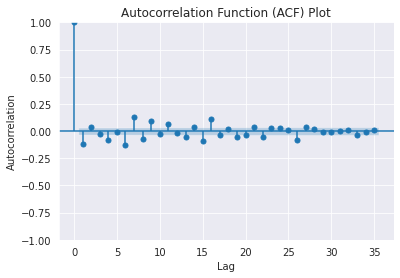

In [24]:

plt.figure(figsize=(10, 6))
plot_acf(data_diff, lags=35)  # You can adjust the 'lags' parameter as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

# The seasonal autocorrelation and differenced autocorrelation are different, which implies that the time series data contains both seasonal patterns and non-seasonal patterns. 

In [25]:
pip install stldecompose


Note: you may need to restart the kernel to use updated packages.


In [26]:
data_copy1=data.copy()

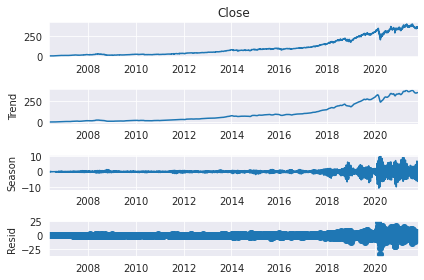

In [27]:
from statsmodels.tsa.seasonal import STL

df3=data_copy1['Close']

# Perform STL decomposition with a period of 15
res = STL(df3, period=15).fit()

# Plot the decomposition
res.plot()
plt.show()

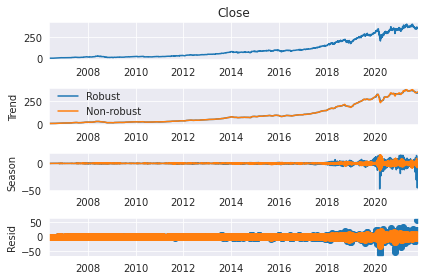

In [28]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(df3, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(df3, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

# Plot and Calculate Daily Returns

# Value at risk testing

In [29]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')

# Calculate the daily returns as a percentage change
Returns = df["Close"].pct_change()
print(Returns)




0            NaN
1      -0.023261
2      -0.020699
3       0.021363
4       0.057187
          ...   
3867   -0.002876
3868    0.015967
3869    0.016253
3870    0.002967
3871   -0.022002
Name: Close, Length: 3872, dtype: float64


In [30]:
# Compute the 95% VaR using the historical method
var_99 = Returns.quantile(0.001)
print(var_99)

-0.10343960567306963


we are 99.9% confident that the stock will not lose more than 10% of its value in a single day

In [31]:
df["Returns"] = Returns

In [32]:
Returns.head(100)

0          NaN
1    -0.023261
2    -0.020699
3     0.021363
4     0.057187
        ...   
95   -0.012225
96   -0.033514
97    0.013093
98   -0.004545
99    0.017264
Name: Close, Length: 100, dtype: float64

In [33]:
Returns.dropna()

1      -0.023261
2      -0.020699
3       0.021363
4       0.057187
5      -0.010945
          ...   
3867   -0.002876
3868    0.015967
3869    0.016253
3870    0.002967
3871   -0.022002
Name: Close, Length: 3871, dtype: float64

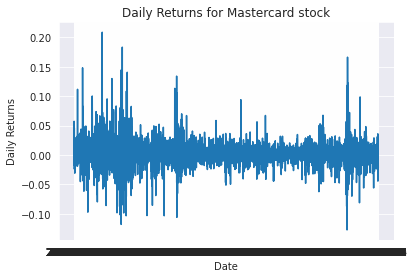

In [34]:
# Plot the daily returns
plt.plot(df['Date'], df['Returns'])
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Daily Returns for Mastercard stock')
plt.show()



# Checking the Summary Statistics

In [35]:
# Calculate some summary statistics of the daily returns
mean_return = df['Returns'].mean()
std_return = df['Returns'].std()
max_return = df['Returns'].max()
min_return = df['Returns'].min()

print(f"Mean daily return: {mean_return:.4f}")
print(f"Standard deviation of daily returns: {std_return:.4f}")
print(f"Maximum daily return: {max_return:.4f}")
print(f"Minimum daily return: {min_return:.4f}")

Mean daily return: 0.0014
Standard deviation of daily returns: 0.0217
Maximum daily return: 0.2085
Minimum daily return: -0.1273


In [36]:
df['Returns'].describe()

count    3871.000000
mean        0.001370
std         0.021701
min        -0.127255
25%        -0.008186
50%         0.001333
75%         0.010246
max         0.208463
Name: Returns, dtype: float64

# Checking Normality 

In [37]:
from scipy.stats import skew, kurtosis

# Calculate skewness and kurtosis of daily returns
skewness = skew(df['Returns'].dropna())
kurtosis = kurtosis(df['Returns'].dropna())

print('Skewness: {:.2f}'.format(skewness))
print('Kurtosis: {:.2f}'.format(kurtosis))


Skewness: 0.71
Kurtosis: 10.09


**The skewness value indicates that the distribution of daily returns is slightly right-tailed while a kurtosis greater than 3 indicates that it is leptokurtic i.e it has  heavier tails than a normal distribution.**

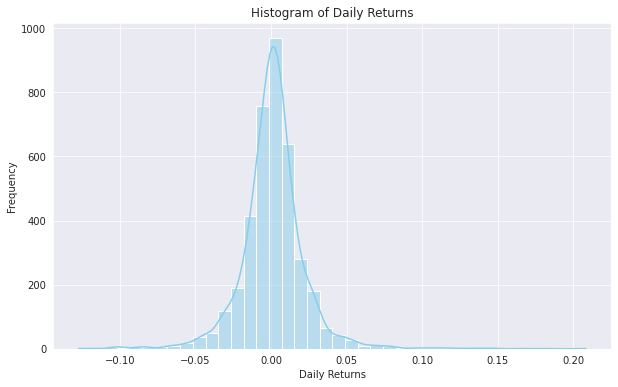

In [38]:
import seaborn as sns

# histogram of daily returns with KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Returns'], bins=40, kde=True, color='skyblue')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.show()



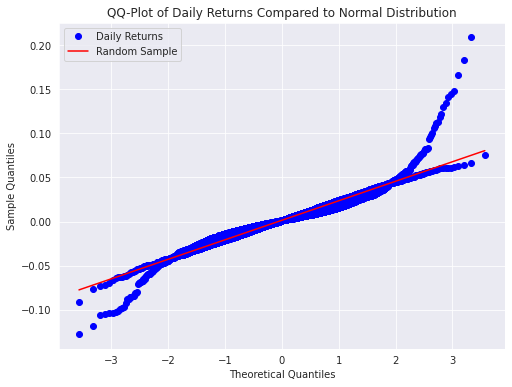

In [39]:
# Create QQ-plot of daily returns compared to a normal distribution
plt.figure(figsize=(8, 6))
stats.probplot(df['Returns'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ-Plot of Daily Returns Compared to Normal Distribution')

# Generate a random sample from a normal distribution with the same size as daily returns
random_sample = np.random.normal(np.mean(df['Returns']), np.std(df['Returns']), len(df['Returns']))

# Create QQ-plot for the random sample
stats.probplot(random_sample, dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ-Plot of Daily Returns Compared to Normal Distribution')

#legends to differentiate between plots
plt.legend(['Daily Returns', 'Random Sample'])

plt.show()


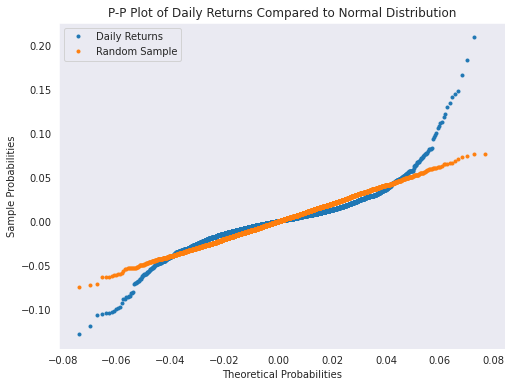

In [40]:
# Create P-P plot of daily returns compared to a normal distribution
plt.figure(figsize=(8, 6))
sorted_returns = np.sort(df['Returns'])
n = len(sorted_returns)
pp = (np.arange(n) + 1) / (n + 1)
theoretical_quantiles = stats.norm.ppf(pp, loc=np.mean(df['Returns']), scale=np.std(df['Returns']))
plt.plot(theoretical_quantiles, sorted_returns, marker='.', linestyle='none', label='Daily Returns')

# Generate a random sample from a normal distribution with the same size as daily returns
random_sample = np.random.normal(np.mean(df['Returns']), np.std(df['Returns']), len(df['Returns']))
sorted_random_sample = np.sort(random_sample)
plt.plot(theoretical_quantiles, sorted_random_sample, marker='.', linestyle='none', label='Random Sample')

plt.xlabel('Theoretical Probabilities')
plt.ylabel('Sample Probabilities')
plt.title('P-P Plot of Daily Returns Compared to Normal Distribution')
plt.legend()
plt.grid()
plt.show()

From p-p and q-q plots its also clear that tha daily returns distribution is not normal

# VaR at 95%

In [41]:
df= pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', parse_dates=["Date"], index_col="Date")

# Calculate the daily returns as a percentage change for Open, High, and Low columns
returns_open = df["Open"].pct_change()
returns_high = df["High"].pct_change()
returns_low = df["Low"].pct_change()
returns_close = df["Close"].pct_change()

# Compute the 95% VaR using the historical method for Open, High, and Low columns
var_95_open = returns_open.quantile(0.05)
var_95_high = returns_high.quantile(0.05)
var_95_low = returns_low.quantile(0.05)
var_95_close = returns_low.quantile(0.05)


print("95% VaR for Open column:", var_95_open)
print("95% VaR for High column:", var_95_high)
print("95% VaR for Low column:", var_95_low)
print("95% VaR for Close column:", var_95_close)


95% VaR for Open column: -0.030498458787065086
95% VaR for High column: -0.025279920772427522
95% VaR for Low column: -0.028914863554018733
95% VaR for Close column: -0.028914863554018733


The VAR Test at 95% confidence is more or less stable across open,close,high and low columns 

In [42]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [43]:
df1=df.drop('Dividends',axis=1)
df2=df1.drop('Stock Splits',axis=1)

In [44]:
# Perform Shapiro-Wilk normality test
shapiro_test = stats.shapiro(Returns)
shapiro_statistic, shapiro_p_value = shapiro_test
print('Shapiro-Wilk Test')
print('Statistic:', shapiro_statistic)
print('p-value:', shapiro_p_value)

# Perform Anderson-Darling normality test
anderson_test = stats.anderson(Returns, dist='norm')
anderson_statistic, anderson_critical_values, anderson_significance_levels = anderson_test
print('\nAnderson-Darling Test')
print('Statistic:', anderson_statistic)
print('Critical Values:', anderson_critical_values)
print('Significance Levels:', anderson_significance_levels)

Shapiro-Wilk Test
Statistic: nan
p-value: 1.0

Anderson-Darling Test
Statistic: nan
Critical Values: [0.575 0.655 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]


In [45]:
import numpy as np
from scipy.stats import chisquare

# Define the null hypothesis
null_hypothesis = "Returns follow a uniform distribution"

# Define the expected distribution
expected_distribution = np.repeat(1/len(Returns), len(Returns))

# Perform the chi-squared goodness-of-fit test
test_stat, p_value = chisquare(f_obs=Returns, f_exp=expected_distribution)

# Print the test results
print("Null Hypothesis: ", null_hypothesis)
print("Expected Distribution: Uniform")
print("Chi-squared Test Statistic: ", test_stat)
print("p-value: ", p_value)


Null Hypothesis:  Returns follow a uniform distribution
Expected Distribution: Uniform
Chi-squared Test Statistic:  nan
p-value:  nan


In [46]:
# Calculate daily returns
returns = df2.pct_change().dropna()

# Print the first few rows of the returns data
print(returns.head(100))

                Open      High       Low     Close    Volume
Date                                                        
2006-05-26  0.148884  0.014984  0.097264 -0.023261 -0.739355
2006-05-30 -0.028726 -0.037655 -0.028565 -0.020699 -0.515760
2006-05-31 -0.013787  0.008448  0.035006  0.021363 -0.398733
2006-06-01  0.013078  0.060406  0.012401  0.057187  1.077995
2006-06-02  0.079457  0.012474  0.042093 -0.010945 -0.402461
...              ...       ...       ...       ...       ...
2006-10-11 -0.002811 -0.030716 -0.031489 -0.033514  0.325773
2006-10-12 -0.026075 -0.002535  0.006444  0.013093 -0.573965
2006-10-13  0.027496  0.012426  0.016007 -0.004545 -0.251108
2006-10-16 -0.014084  0.000139  0.000430  0.017264 -0.222507
2006-10-17  0.015715 -0.007112 -0.008303 -0.025245  0.120768

[100 rows x 5 columns]


In [47]:
data_copy = df2.copy()


In [48]:


# Check for stationarity
def adfuller_test(series, signif=0.05):
    adf_test = sm.tsa.stattools.adfuller(series, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    if adf_output['p-value'] <= signif:
        print(f"ADF test indicates that the series {series.name} is stationary.")
    else:
        print(f"ADF test indicates that the series {series.name} is non-stationary.")
    return adf_output


# Apply adfuller_test function to each column
for col in data_copy.columns:
    adfuller_test(data_copy[col])

ADF test indicates that the series Open is non-stationary.
ADF test indicates that the series High is non-stationary.
ADF test indicates that the series Low is non-stationary.
ADF test indicates that the series Close is non-stationary.
ADF test indicates that the series Volume is stationary.


In [49]:
import scipy.stats as stats

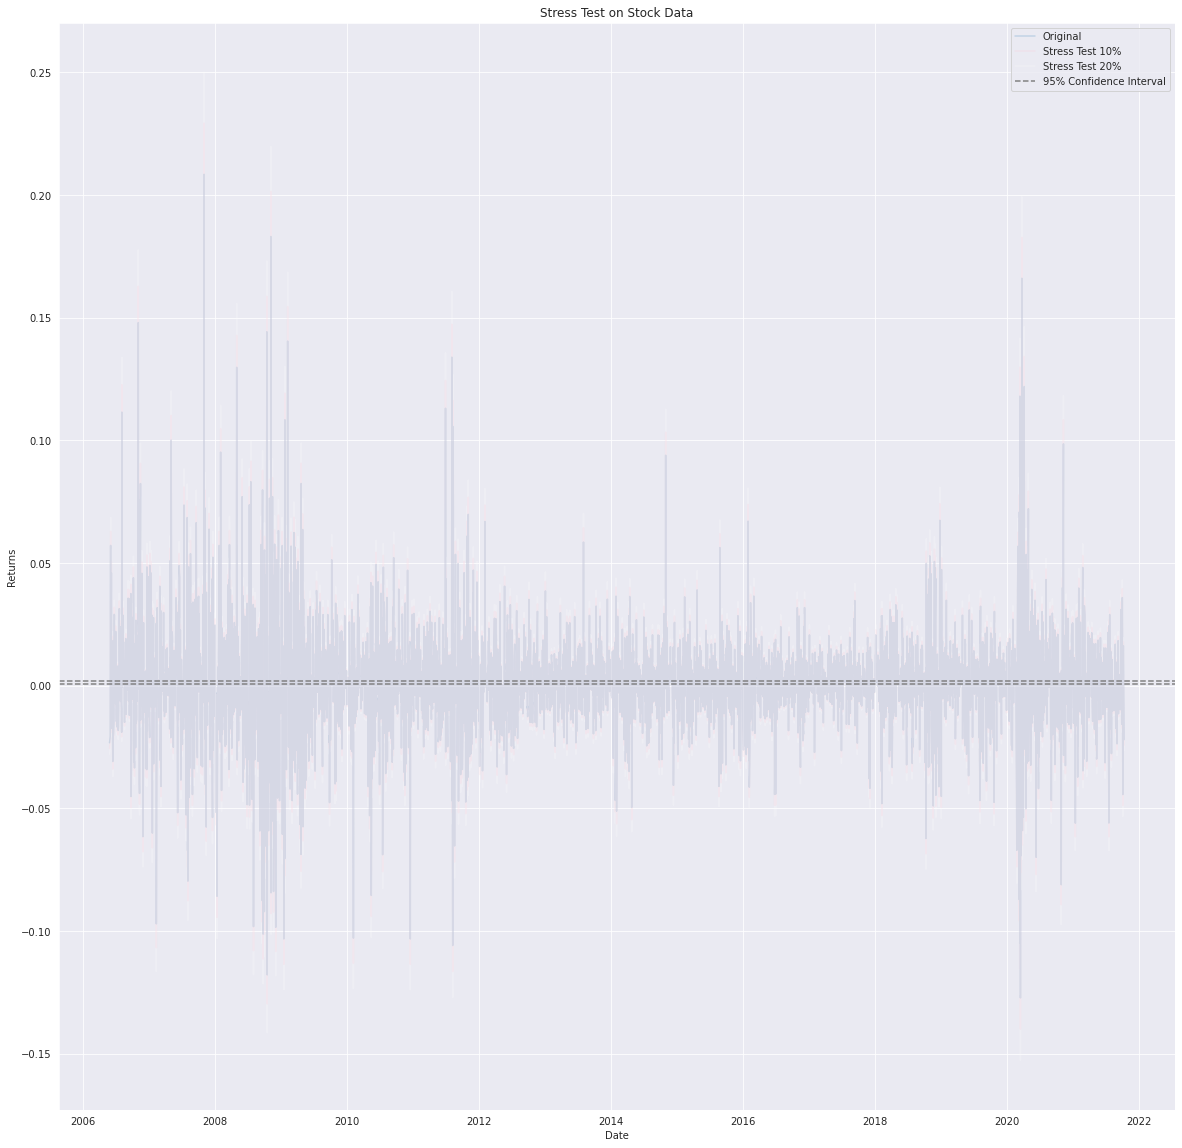

In [50]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Calculate volatility
df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(252)

# Define stress test function
def stress_test(df, pct_change):
    """
    Simulate a stress test on the stock data by applying a percentage change to the returns.
    """
    df_stress = df.copy()
    df_stress['Returns'] = df_stress['Returns'] * (1 + pct_change)
    df_stress['Close'] = df_stress['Close'].shift(1) * (1 + df_stress['Returns'])
    return df_stress

# Define confidence interval function
def calculate_confidence_interval(df, alpha=0.05):
    """
    Calculate the confidence interval for the stock returns based on the given alpha level.
    """
    n = len(df)
    mean_return = df['Returns'].mean()
    std_error = df['Returns'].std() / np.sqrt(n)
    t_value = abs(stats.t.ppf(alpha/2, n-1))
    lower_bound = mean_return - t_value * std_error
    upper_bound = mean_return + t_value * std_error
    return (lower_bound, upper_bound)

# Run stress tests and calculate confidence intervals
df_10 = stress_test(df, 0.1)
df_20 = stress_test(df, 0.2)
conf_interval = calculate_confidence_interval(df)

# Plot results
plt.figure(figsize=(20, 20))
plt.plot(df['Returns'], label='Original',alpha=0.2)
plt.plot(df_10['Returns'], label='Stress Test 10%',color='pink',alpha=0.2)
plt.plot(df_20['Returns'], label='Stress Test 20%',color='white',alpha=0.2)
plt.axhline(y=conf_interval[0], linestyle='--', color='gray', label='95% Confidence Interval')
plt.axhline(y=conf_interval[1], linestyle='--', color='gray')
plt.legend()
plt.title('Stress Test on Stock Data')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

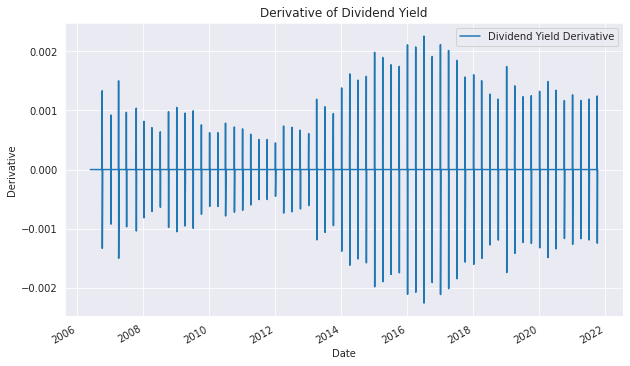

In [51]:
import pandas as pd
import numpy as np


# Calculate dividend yield
df['Dividend Yield'] = df['Dividends'] / df['Close']

# Calculate derivative of dividend yield
df['Dividend Yield Derivative'] = df['Dividend Yield'].diff()

# Plot results
df[['Dividend Yield Derivative']].plot(figsize=(10, 6))
plt.title('Derivative of Dividend Yield')
plt.xlabel('Date')
plt.ylabel('Derivative')
plt.show()


In [52]:
# Make data stationary
data_diff = data_copy.diff().dropna()

# Check for stationarity again
for col in data_diff.columns:
    adfuller_test(data_diff[col])


ADF test indicates that the series Open is stationary.
ADF test indicates that the series High is stationary.
ADF test indicates that the series Low is stationary.
ADF test indicates that the series Close is stationary.
ADF test indicates that the series Volume is stationary.
